# Exploration of the housing prices data set, in prep for data cleansing and model training.

## Import the library

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

## Load the dataset


In [6]:
df = pd.read_csv("data_train.csv")
df = df.drop('Id', axis=1)  # Drop useless Id column (it is not a predictor)
print("Full train dataset shape is {}".format(df.shape))
label = "SalePrice"    # The column that contains the label to predict.

Full train dataset shape is (1460, 80)


## Target Distribution

Let look at the distribution of the target label, SalePrice.

Original SalePrice
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Skewness: 1.882876
Kurtosis: 6.536282


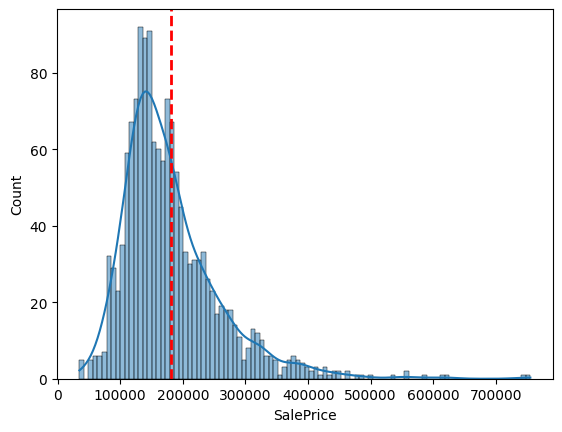

Log transformed SalePrice
count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64
Skewness: 0.121335
Kurtosis: 0.809532


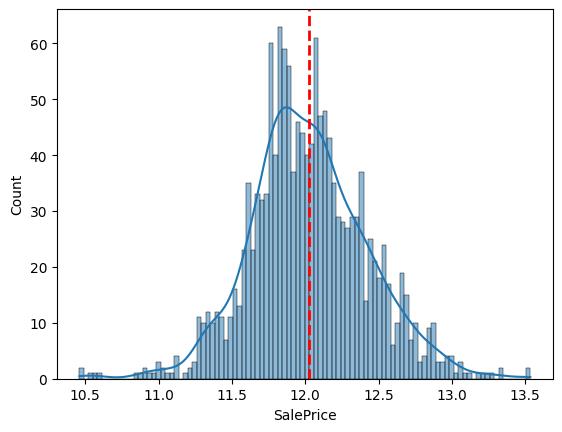

In [10]:
for name, data in zip ([f"Original {label}", f"Log transformed {label}"], [df[label], np.log(df[label])]):
    print (name)
    sns.histplot(data=data, bins=100, kde=True)
    plt.axvline(data.mean(), color='red', linestyle='dashed', linewidth=2)
    print(data.describe())                 # Includes mean and sd (the first and second moments - see https://en.wikipedia.org/wiki/Standardized_moment)
    print("Skewness: %f" % data.skew())    # Third moment measures symmetry (0 = symmetric, positive = right-skewed, negative = left-skewed)
    print("Kurtosis: %f" % data.kurt())    # Fourth moment measures "taileness" (0 = normal, positive = heavy-tailed, negative = light-tailed)
    plt.show()

## Analyize null counts across all features

Percent nulls per feature (out of 1460 samples):
PoolQC          99.52
MiscFeature     96.30
Alley           93.76
Fence           80.75
MasVnrType      59.72
FireplaceQu     47.26
LotFrontage     17.73
GarageYrBlt      5.54
GarageType       5.54
GarageFinish     5.54
GarageQual       5.54
GarageCond       5.54
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.54
Electrical       0.06
dtype: float64


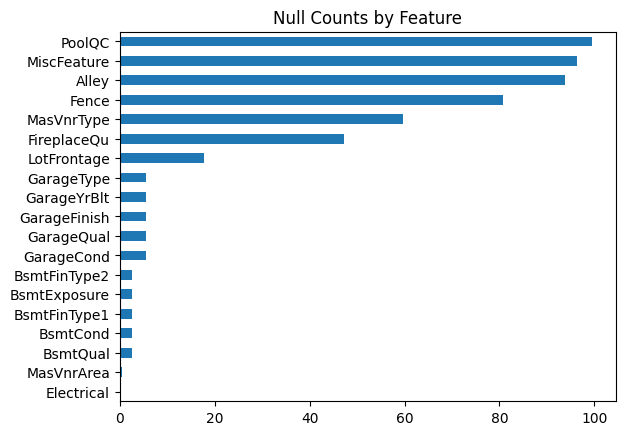

In [15]:
# Show null counts by feature
def show_nulls (dataframe):
    null_counts = dataframe.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    null_counts = null_counts * 10000 / dataframe.shape[0] // 1 / 100    # Convert to percentage with 2 decimal places
    if null_counts.empty:
        print ('No nulls found')
        return
    print (f"Percent nulls per feature (out of {len(dataframe)} samples):")
    null_counts = null_counts.sort_values(ascending=True)
    null_counts.plot.barh()
    plt.title('Null Counts by Feature')
    null_counts = null_counts.sort_values(ascending=False)
    print (null_counts)

show_nulls(df)

## Numerical data overview

We will now take a look at how the numerical features are distributed, and their correlation to the target.

Correlation of numeric features to SalePrice in descending order:

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.1285

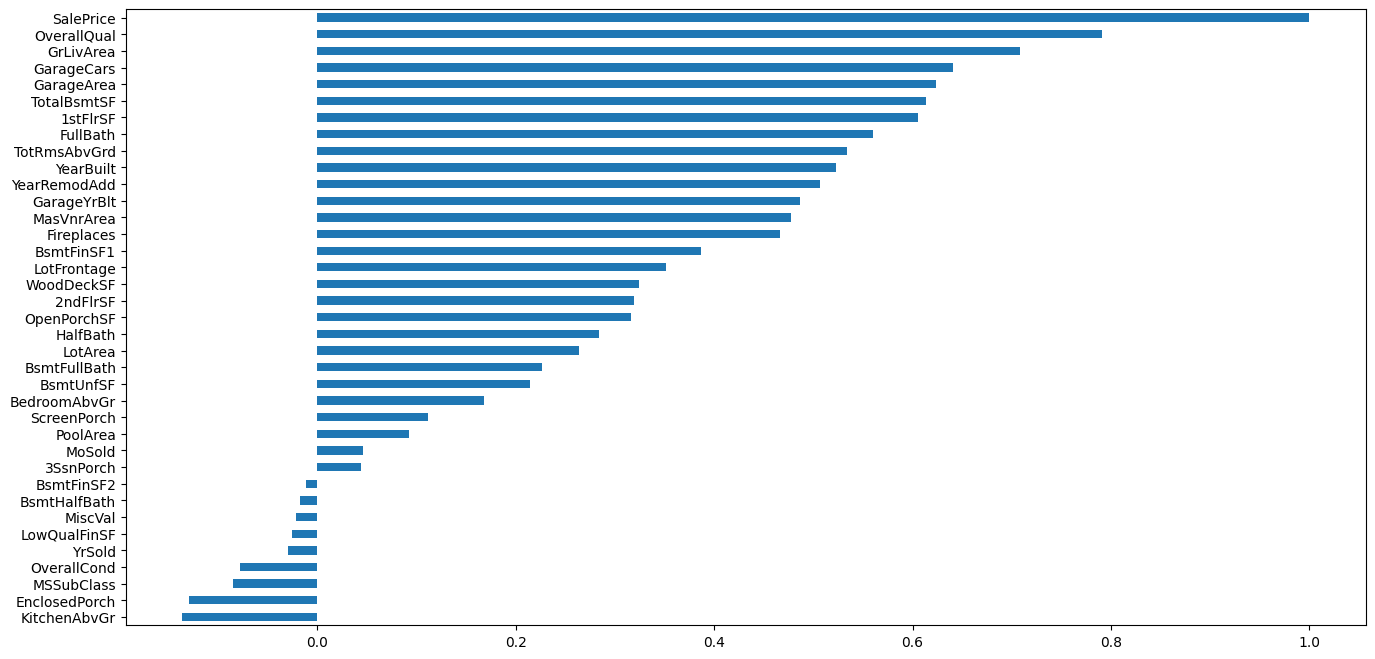

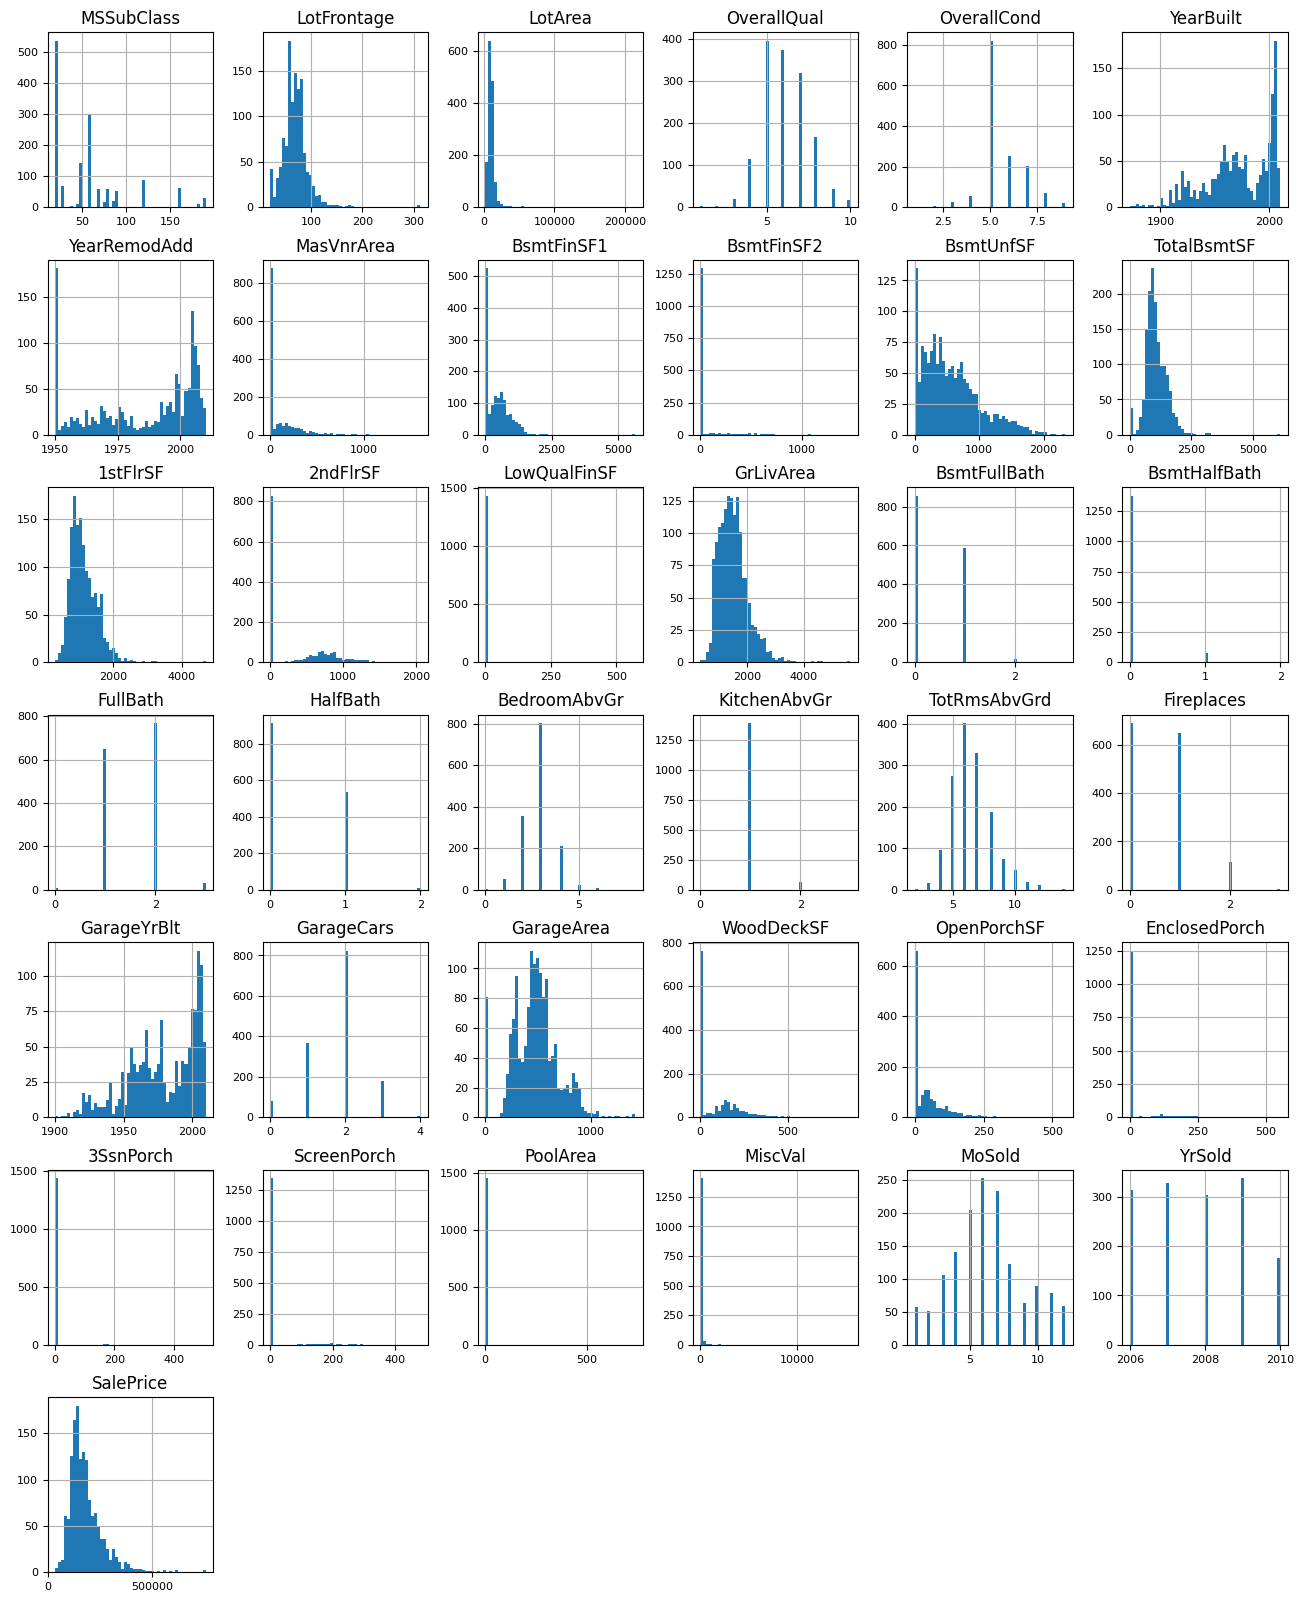

In [5]:
df_num = df.select_dtypes(include=[np.number])  # Numeric features

corr = df_num.corr()
print (f"Correlation of numeric features to {label} in descending order:\n")
corr = corr.sort_values(label, ascending=False)
print (corr[label])
# Plot correlations against label
corr = corr.sort_values(label, ascending=True)
corr[label].plot.barh(figsize=(16, 8));

df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Discreet numeric data analysis

Analyzing discreet numeric features (less than 20 unique values)
No nulls found


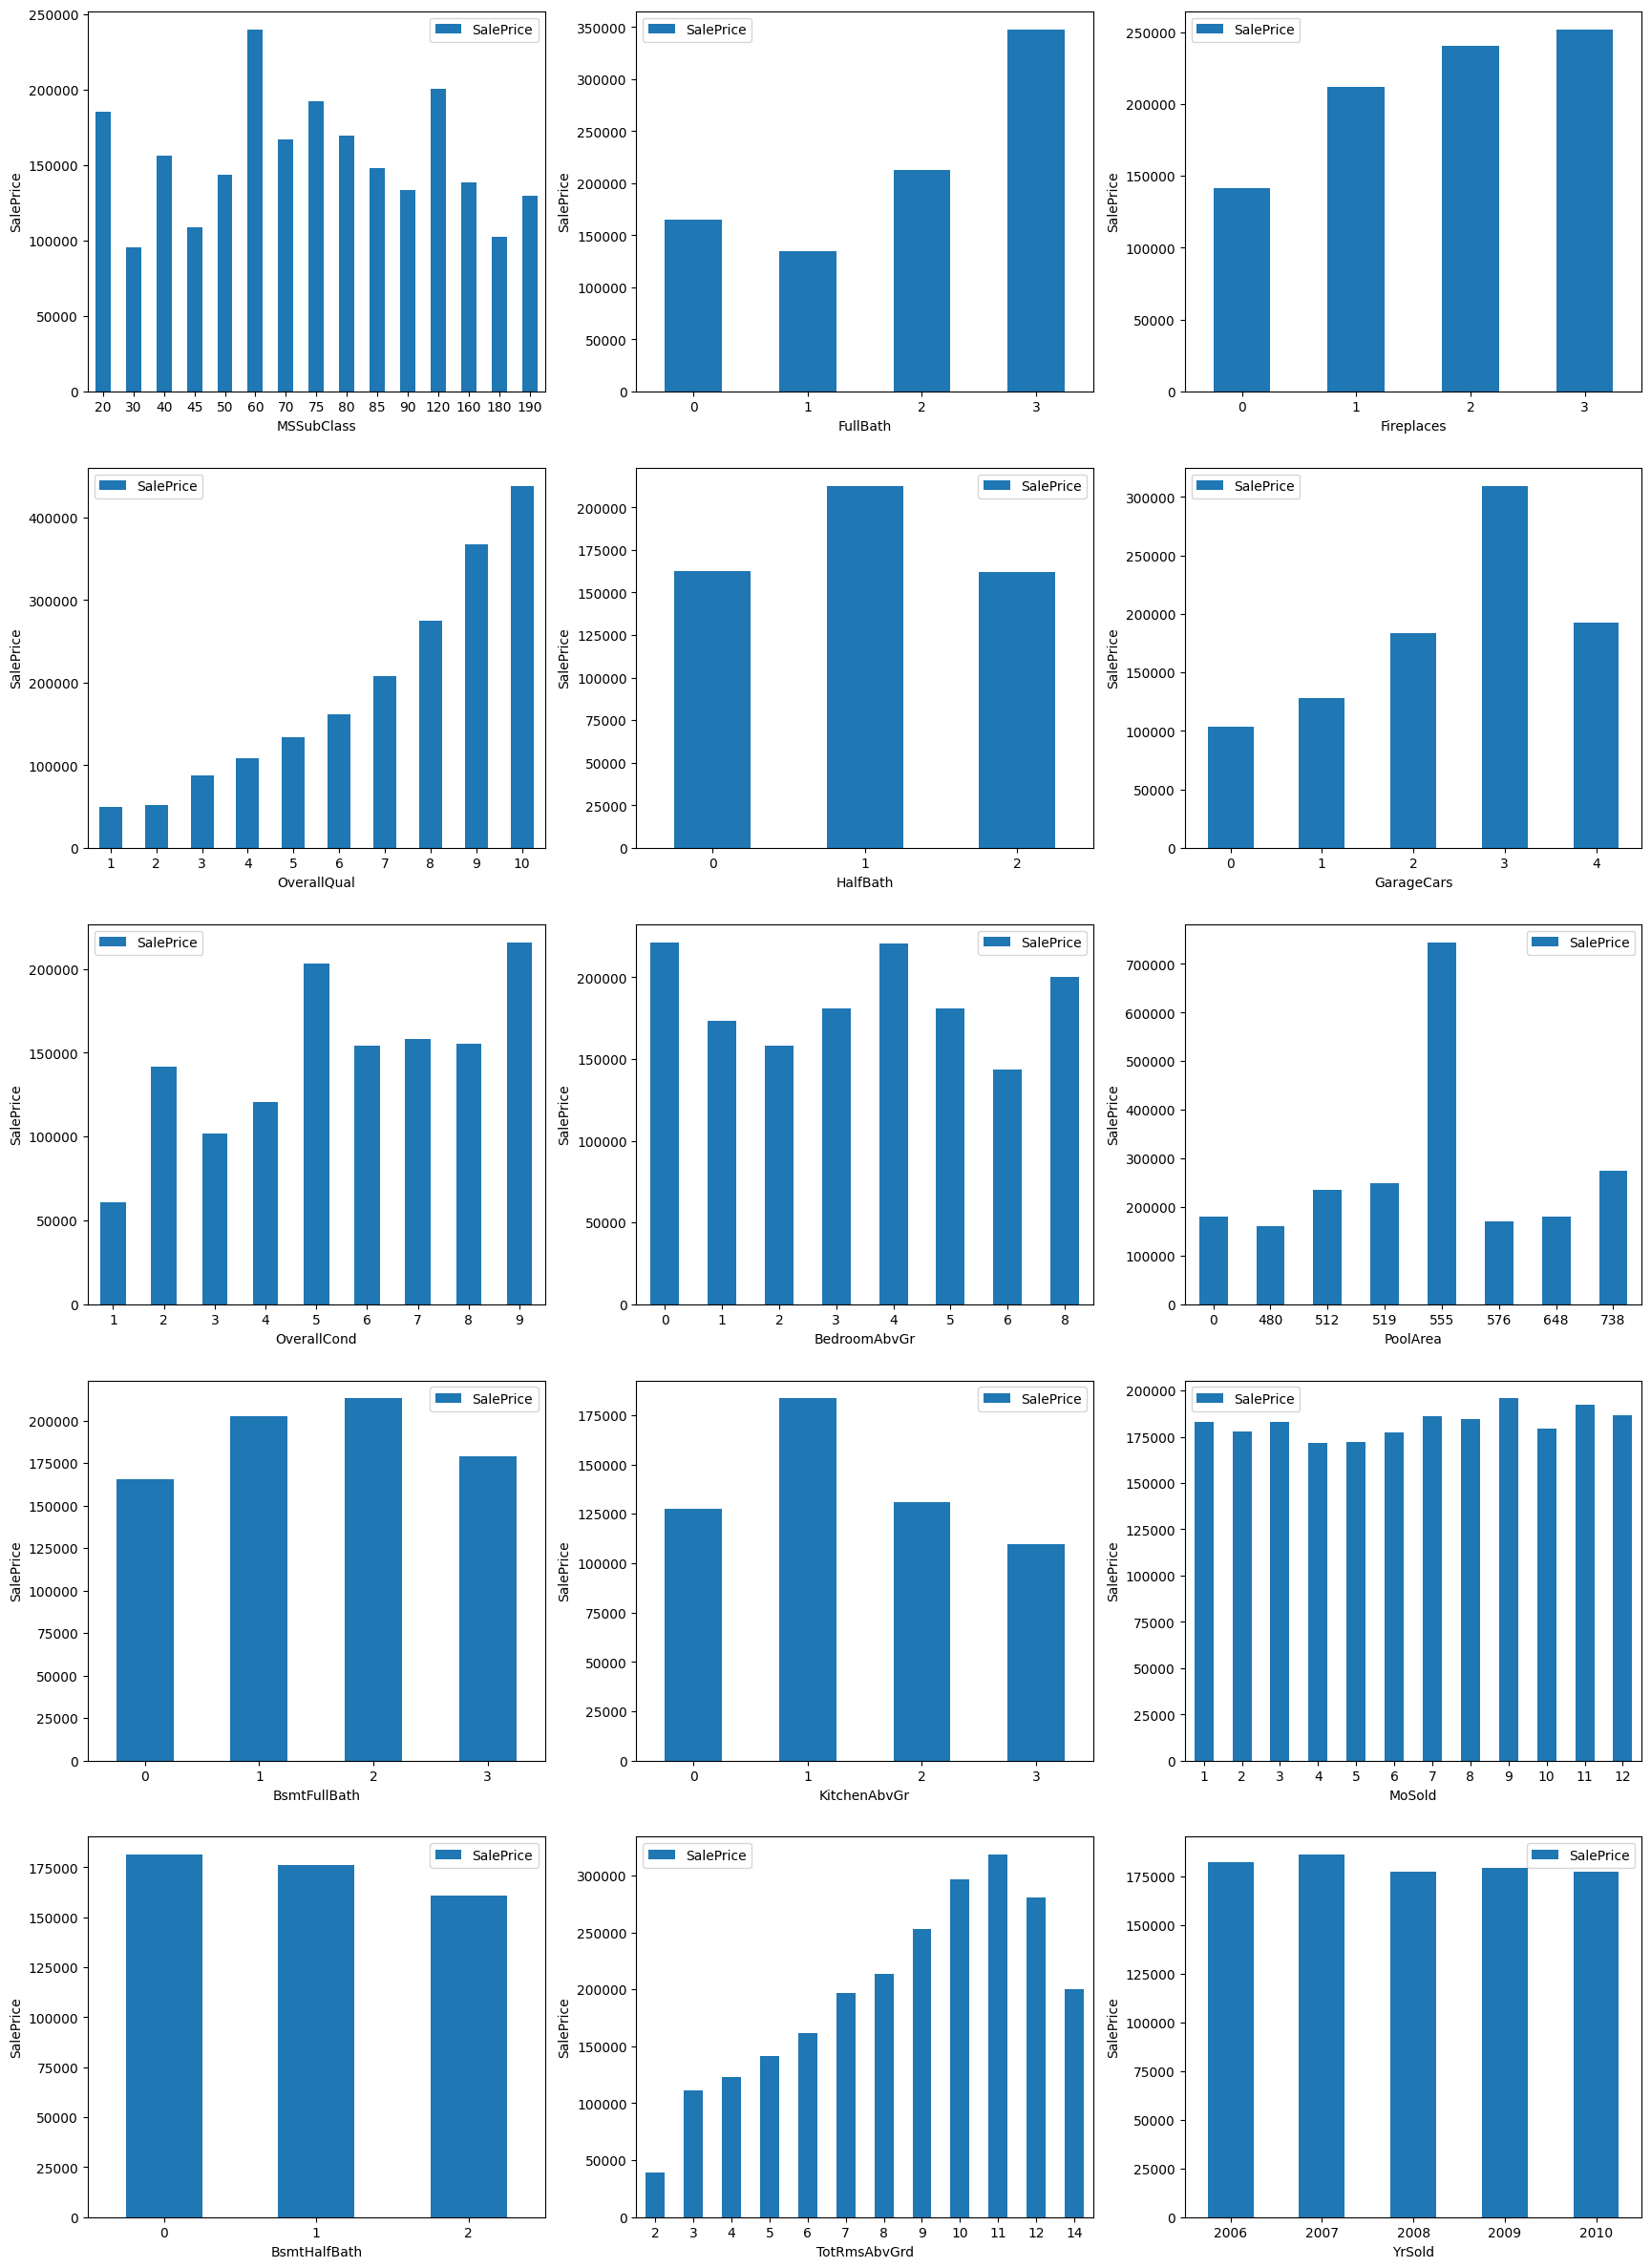

In [35]:
def analyze_discreet_numeric_features(dataframe, max_unique_values=20):
    print (f"Analyzing discreet numeric features (less than {max_unique_values} unique values)")

    df_num = dataframe.select_dtypes(include=[np.number])
    df_num_discreet = df_num[[col for col in df_num.columns if df_num[col].nunique() < max_unique_values]]         # Discrete numeric features (only has a small number of values)

    show_nulls(df_num_discreet)

    # For each feature in df_num_discreet, plot the feature value vs the average SalePrice for that value
    ncols = 3
    nrows = int(np.ceil(len(df_num_discreet.columns)/ncols))
    _, axes = plt.subplots(nrows, ncols, figsize=(ncols*7, nrows*6))
    for i, feature in enumerate(df_num_discreet.columns):
        if nrows == 1:
            ax = axes[i]
        else:
            ax = axes[i%nrows, i//nrows]    #axes[i%nrows][i//nrows]
        price_by_feature = dataframe[[feature, label]].groupby(feature).mean()
        price_by_feature.plot.bar(ax=ax)
        ax.set_ylabel(label)
        ax.set_xlabel(feature)
        ax.set_xticklabels(price_by_feature.index, rotation=0)
    plt.show()

analyze_discreet_numeric_features (df)

## Continuous numeric data analysis

Analyzing continuous numeric features (at least 21 unique values)
Nulls per feature:
LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64
Scatter plot of continuous numeric features vs SalePrice


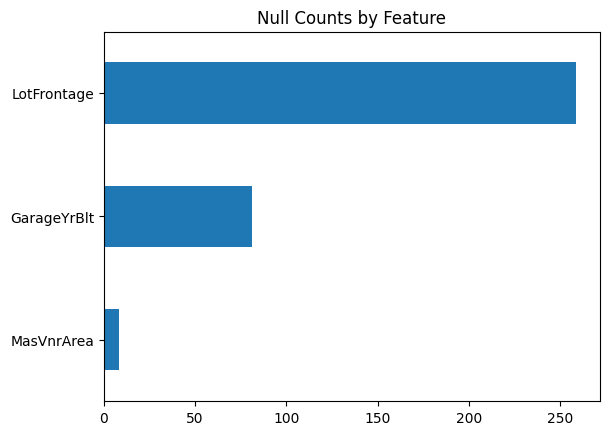

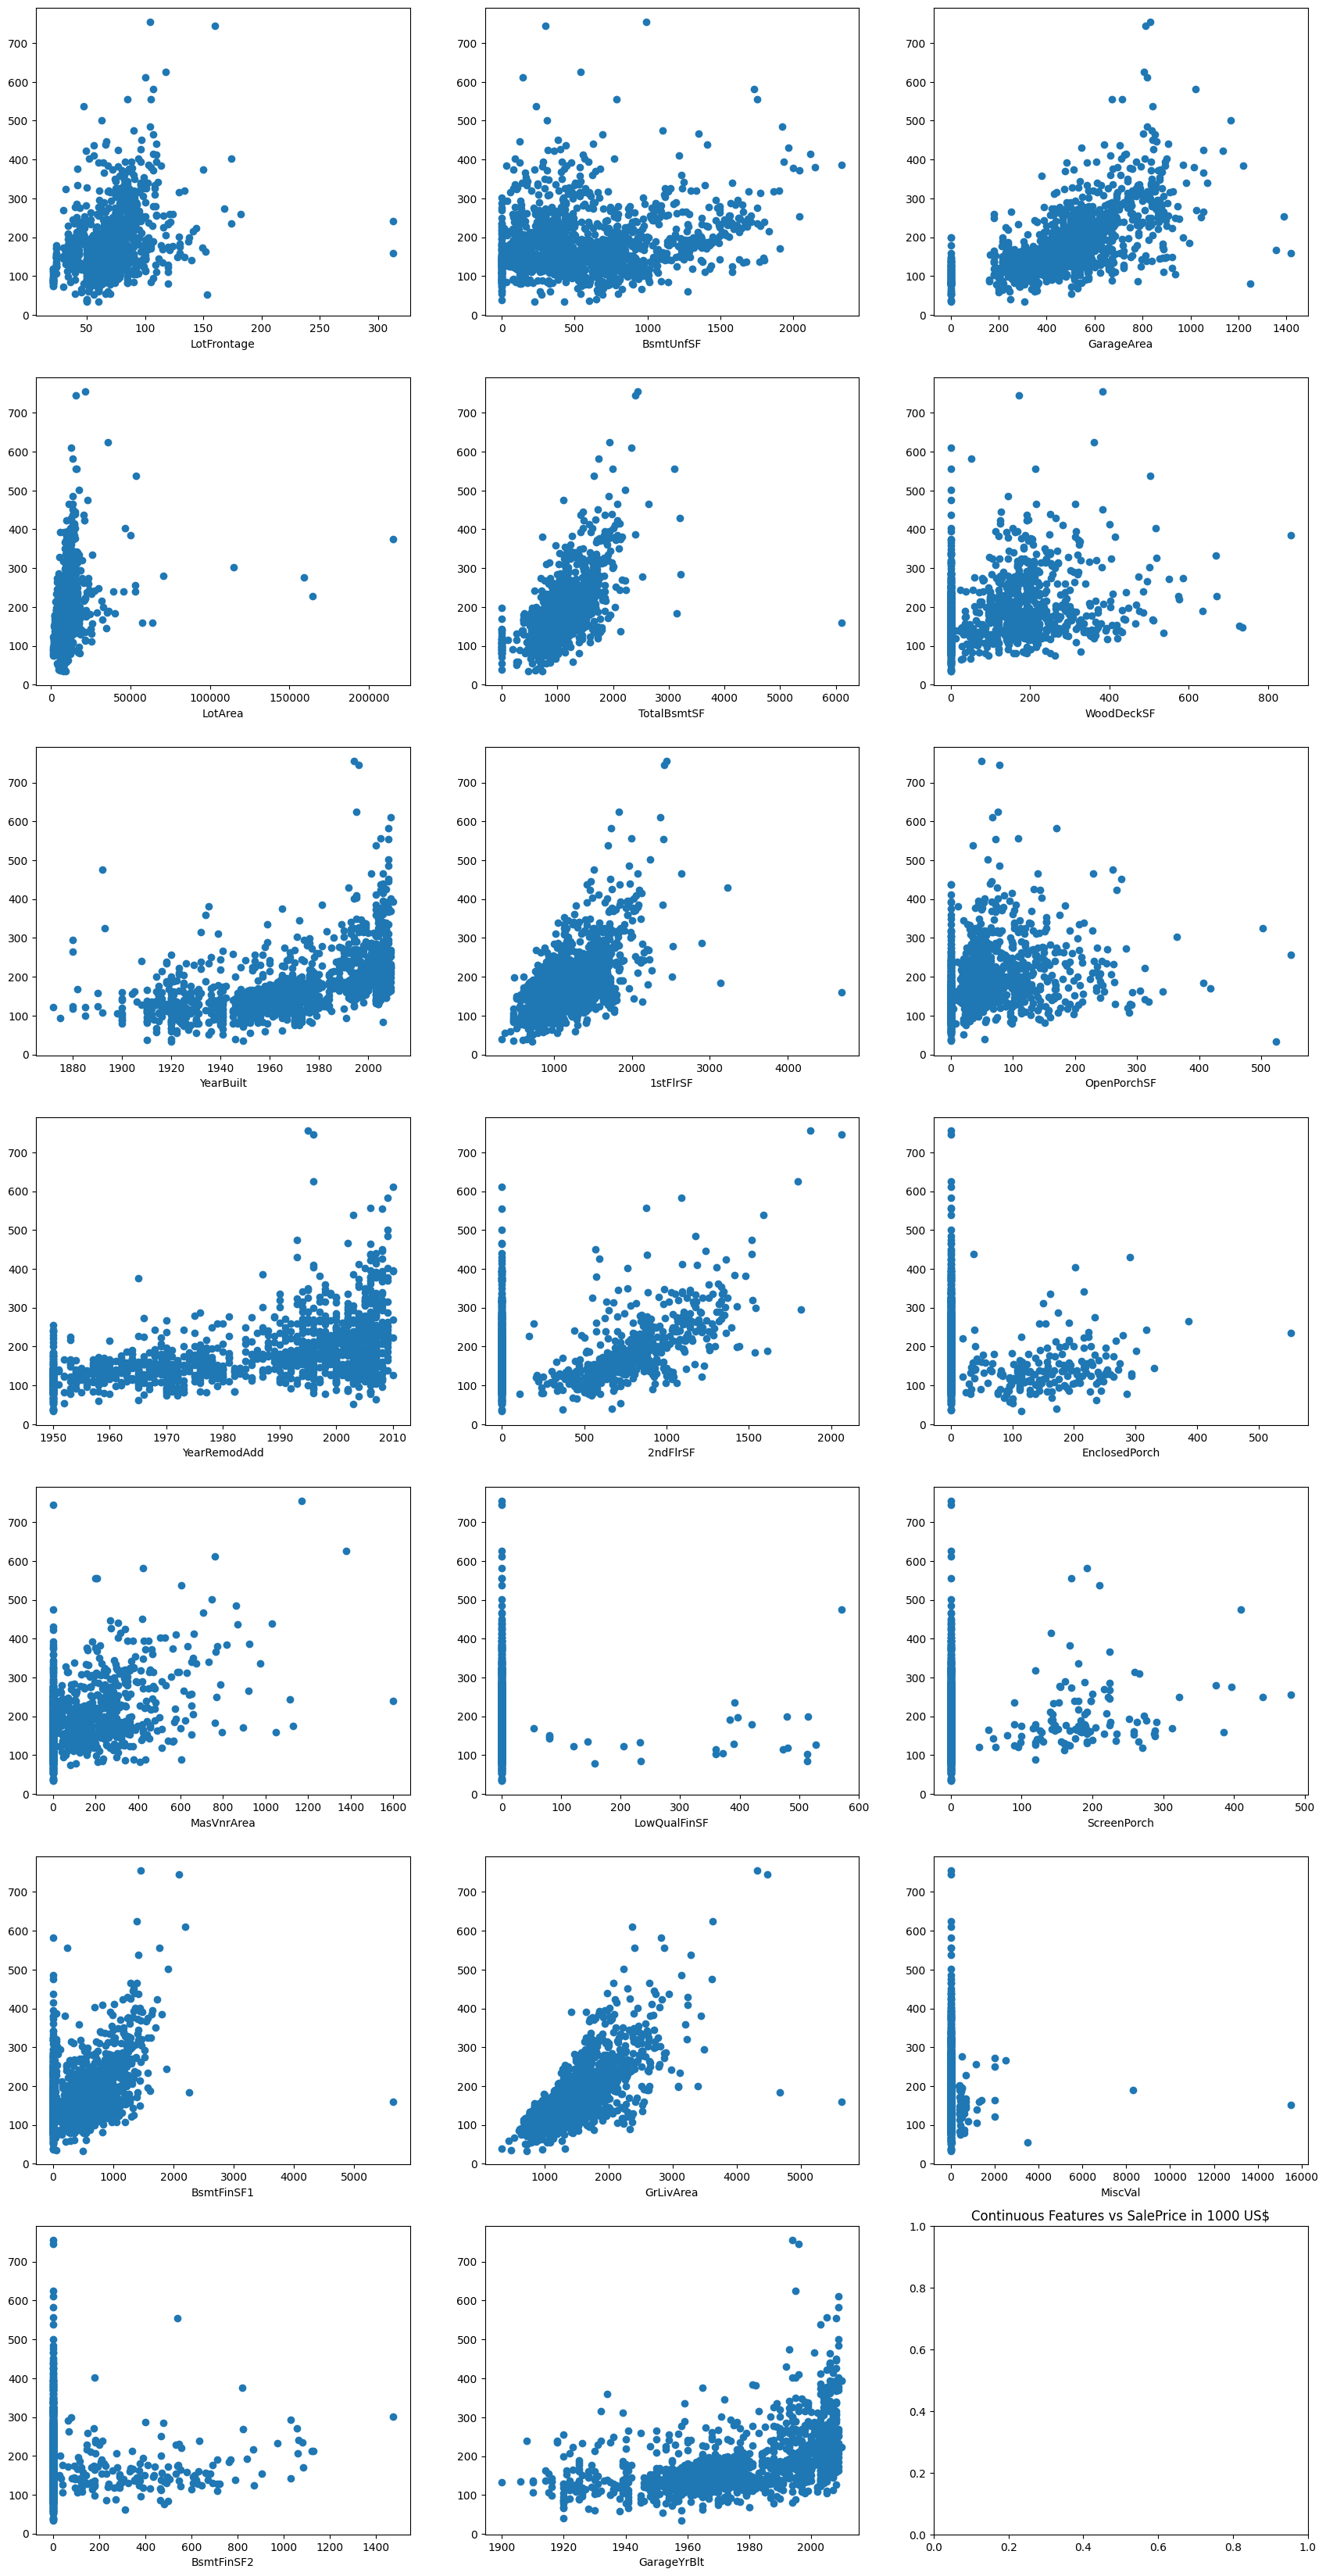

In [36]:
def analyze_continuous_numeric_features(dataframe, min_unique_values=21):
    print (f"Analyzing continuous numeric features (at least {min_unique_values} unique values)")

    df_num = dataframe.select_dtypes(include=[np.number])  # Select only numeric features
    df_num_continuous = df_num[[col for col in df_num.columns if df_num[col].nunique() >= min_unique_values]]      # Continuout numeric features (has a large number of values)

    show_nulls(df_num_continuous)

    # For each feature in df_num_continuous, plot the feature value vs the SalePrice
    print (f"Scatter plot of continuous numeric features vs {label}")
    ncols = 3
    nrows = int(np.ceil(len(df_num_continuous.columns)/ncols))
    _, axes = plt.subplots(nrows, ncols, figsize=(ncols*7, nrows*6))
    for i, feature in enumerate(df_num_continuous.columns):
        if feature == label:
            continue
        if nrows == 1:
            ax = axes[i]
        else:
            ax = axes[i%nrows, i//nrows]
        # Create a scatter plot of feature vs SalePrice
        ax.scatter(dataframe[feature], dataframe[label]//1000)
        ax.set_xlabel(feature)
    plt.title ("Continuous Features vs SalePrice in 1000 US$")
    plt.show()

analyze_continuous_numeric_features (df)


## Categorical data analysis

Analyzing categorical features
Nulls per feature:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
Electrical         1
dtype: int64
nrows: 15, ncols: 3, len(df_cat.columns): 43


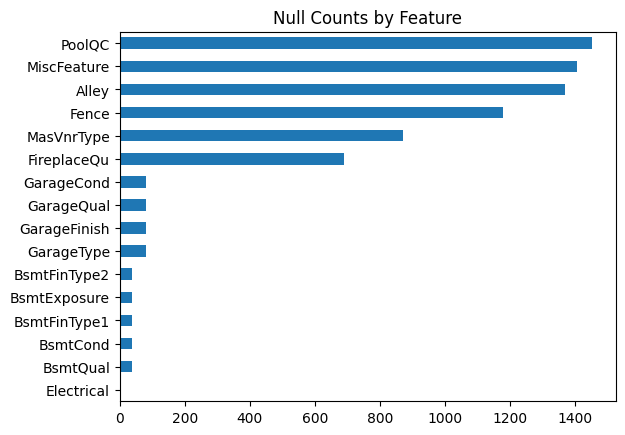

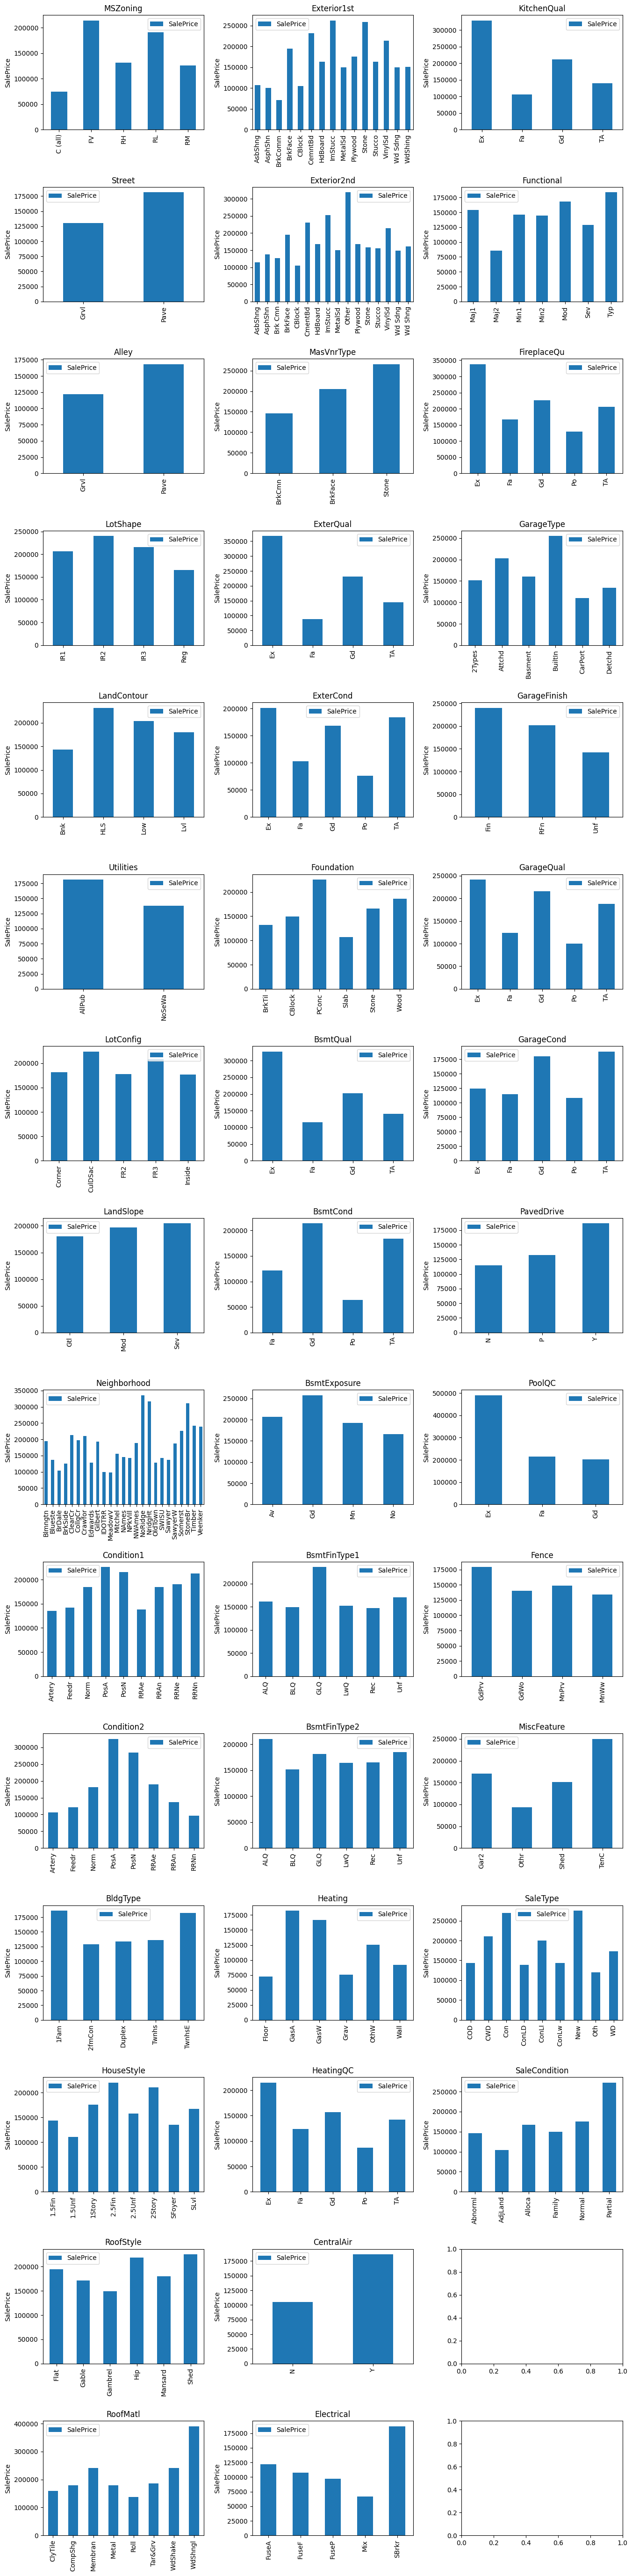

In [10]:
def analyze_categorical_features(dataframe):
    print ("Analyzing categorical features")

    df_cat = dataframe.select_dtypes(include=['object'])   # Categorical features

    show_nulls(df_cat)

    ncols = 3
    nrows = int(np.ceil((len(df_cat.columns))/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 70))
    # Add spacing between plots
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    print (f"nrows: {nrows}, ncols: {ncols}, len(df_cat.columns): {len(df_cat.columns)}")
    for i, feature in enumerate(df_cat.columns):
        ax = axes[i%nrows, i//nrows]
        price_by_cat = df[[feature, label]].groupby(feature).mean()
        price_by_cat.plot.bar(ax=ax)
        ax.set_ylabel(label)
        ax.set_xlabel('')
        #ax.set_yticklabels([])
        ax.set_title(feature)
    plt.show()

analyze_categorical_features(df)


## Manufactored features

Analyzing continuous numeric features (at least 0 unique values)
No nulls found
Scatter plot of continuous numeric features vs SalePrice


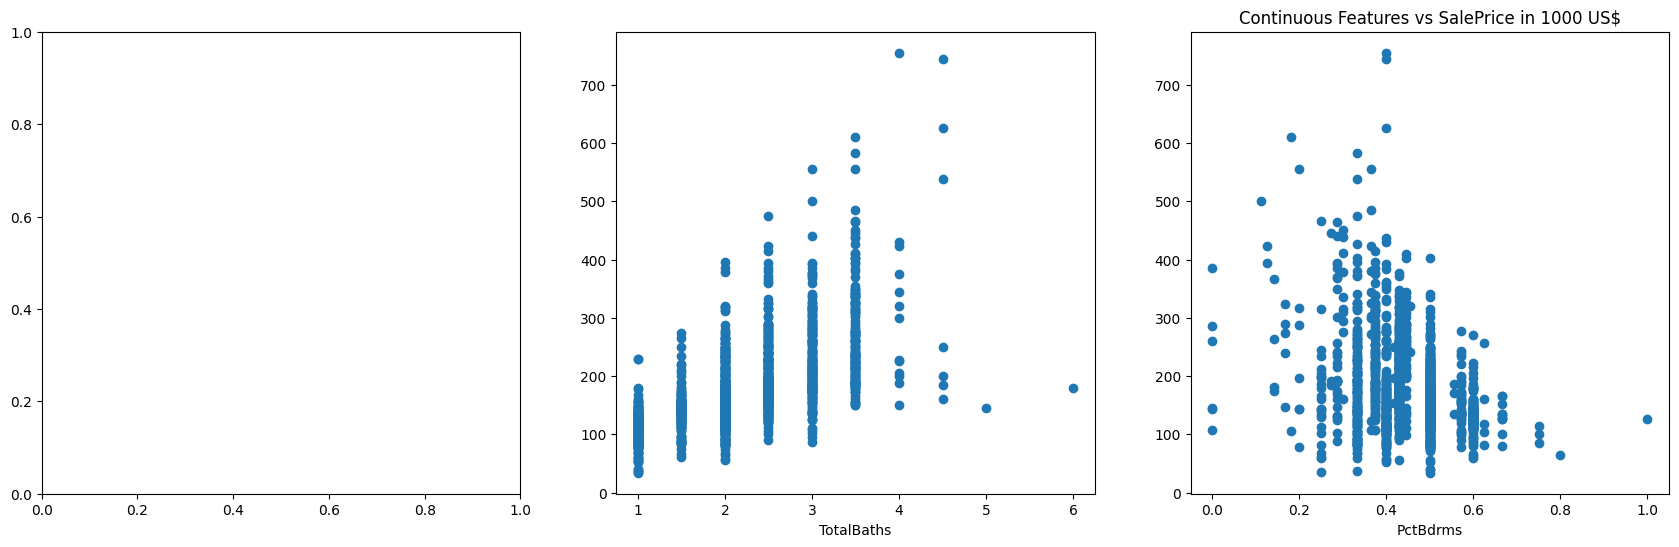

In [39]:
df2 = pd.DataFrame()
df2[label] = df["SalePrice"]
df2["TotalBaths"] = df["FullBath"] + .5* df["HalfBath"] + df["BsmtFullBath"] + .5 * df["BsmtHalfBath"]  # Seems to be a better predictor
df2["PctBdrms"] = df["BedroomAbvGr"] / df["TotRmsAbvGrd"]  # Seems to be a better predictor than BedroomAbvGr
analyze_continuous_numeric_features(df2, 0)

# Note - MSSubClass should be a categorical feature, not a numeric feature
